# Neural Network Classification

## Table of Content
- [Make classification data and get it ready](#getting-ready)
- [Turn data into tensors and create train and test split](#train-test)
- [Building a model](#building)
- [Setup loss function and optimizer](#loss-opt)
- [Train model](#train)
- [Improving our model (from a model's perspective)](#improve)

### Make classification data and get it ready <a class="anchor" id="getting-ready"></a>

In [36]:
import sklearn
import pandas as pd
import matplotlib.pyplot as plt
import torch
import numpy as np

In [37]:
from sklearn.datasets import make_circles

# make 1000 samples
n_samples = 1000

# create circles
X, y = make_circles(n_samples,
                    noise=0.03,
                    random_state=42)

In [38]:
circles = pd.DataFrame({"X1": X[:, 0],
                       "X2": X[:, 1],
                       "label": y})

circles.head(10)

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


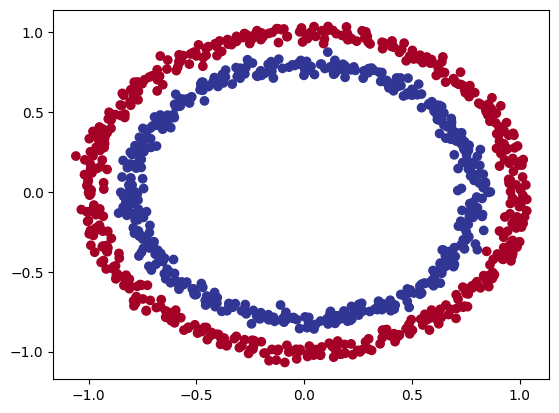

In [39]:
# visualize
plt.scatter(x=X[:, 0],
            y=X[:, 1],
            c=y,
            cmap=plt.cm.RdYlBu)

> **Note:** The data we are dealing with here is called a "toy dataset", a dataset that is small enough to experiment but still sizeable enough to practice the fundamentals. See more: `scikitlearn classification datasets -> Toy datasets`.

### Turn data into tensors and create train and test split <a class="anchor" id="train-test"></a>

In [40]:
# turn data into tensors
X = torch.from_numpy(X).type(torch.float) # float32
y = torch.from_numpy(y).type(torch.float)


X[:5], y[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]))

In [41]:
# split data into train and test sets (80:20)
X_train = X[:int(0.8*len(X))]
y_train = y[:int(0.8*len(y))]

X_test = X[int(0.8*len(X)):]
y_test = y[int(0.8*len(y)):]

In [42]:
# the scikit way
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2, # 20% test data
                                                    random_state=42
                                                   )
len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

### Building a model <a class="anchor" id="building"></a>
Let's build a model to classify our blue and red dots.
To do so, we want to:
1. Setup device agnostic code so our code will run on an accelerator (GPU) if there is one.
2. Construct a model by subclassing `nn.Module`.
3. Define a loss function and optimizer.
4. Create a training and testing loop.

In [43]:
# import PyTorch and nn
import torch
from torch import nn

# make device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

Now we've setup device agnostic code, let's create a model that:
1. Subclasses `nn.Module` (almost all models in PyTorch subclass `nn.Module`).
2. Create 2 `nn.Linear()` layers that are capable of handling the shapes of our data.
3. Defines a `forward()` method that outlines the forward pass (or forward computation) of the model.
4. Instantiate an instance of our model class and send it to the `device`.

In [44]:
# creating our model
from sklearn import datasets

class CircleModelV0(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=5)
        self.layer_2 = nn.Linear(in_features=5, out_features=1)

    def forward(self, x:torch.Tensor) -> torch.Tensor:
        return self.layer_2(self.layer_1(x))

# create an instance of the model
model_0 = CircleModelV0().to(device)
model_0

CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [45]:
# making the model with nn.Sequntial()
model_0 = nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5, out_features=1)
).to(device)

model_0.state_dict()

OrderedDict([('0.weight',
              tensor([[ 0.5035,  0.0728],
                      [ 0.5461, -0.2831],
                      [ 0.3831,  0.2748],
                      [ 0.3131, -0.0876],
                      [-0.4633,  0.1937]])),
             ('0.bias', tensor([ 0.6356, -0.4774, -0.2208, -0.3915,  0.5174])),
             ('1.weight',
              tensor([[ 0.2250, -0.1528, -0.0051,  0.4422, -0.2709]])),
             ('1.bias', tensor([-0.3887]))])

### Setup loss function and optimizer <a class="anchor" id="loss-opt"></a> 
Which loss function or optimizer should you use?

For example, for regression you might want MAE or MSE (mean absolute error or mean square error).

FOr classification, you might want binary cross entropy or categorical cross entropy (cross entropy).

As a reminder, the loss function measures how *wrong* our predictions are.

And for optimizers, two o the most common and useful are SGD and Adam, however, PyTorch has many built-in optimizers.


In [46]:
# loss functions and optimizers
loss_fn = nn.BCEWithLogitsLoss() # cross entropy with sigmoid activation

optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr=0.01)

### Train model <a class="anchor" id="train"></a>

Our model outputs are going to be raw **logits**.

We can convert these **logits** into prediction probabilities by passing them to some kind of activation function (e.g., sigmoid for binary classification and softmax for multiclass classification).

In [47]:
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

from sklearn.metrics import accuracy_score

epochs = 1000
epoch_count = []
train_loss = []
test_loss = []
test_accuracy_count = []

for epoch in range(epochs):
    model_0.train()
    y_logits = model_0(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits)) # turn logits into predictions
    
    loss = loss_fn(y_logits, y_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    model_0.eval()
    with torch.inference_mode():
        y_eval_logits = model_0(X_test).squeeze()
        y_eval = torch.round(torch.sigmoid(y_eval_logits))
        loss_test = loss_fn(y_eval_logits, y_test)
        test_accuracy = accuracy_score(y_pred=y_eval, y_true=y_test)
    if epoch%50==0:
        epoch_count.append(epoch)
        train_loss.append(loss)
        test_loss.append(loss_test)
        test_accuracy_count.append(test_accuracy)


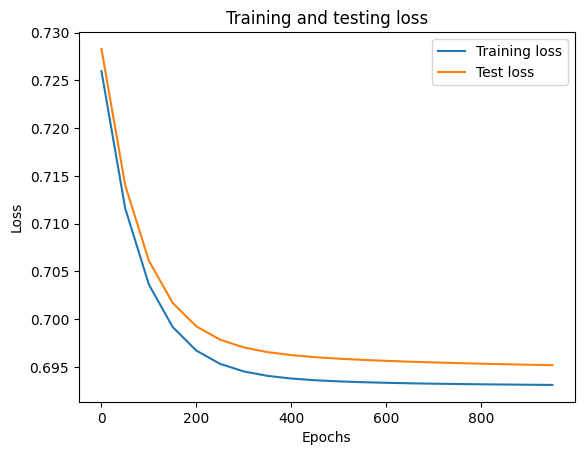

In [48]:
# plotting loss
plt.plot(epoch_count, np.array(torch.tensor(train_loss).numpy()), label="Training loss")
plt.plot(epoch_count, np.array(torch.tensor(test_loss).numpy()), label="Test loss")
plt.title("Training and testing loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

Text(0, 0.5, 'Accuracy')

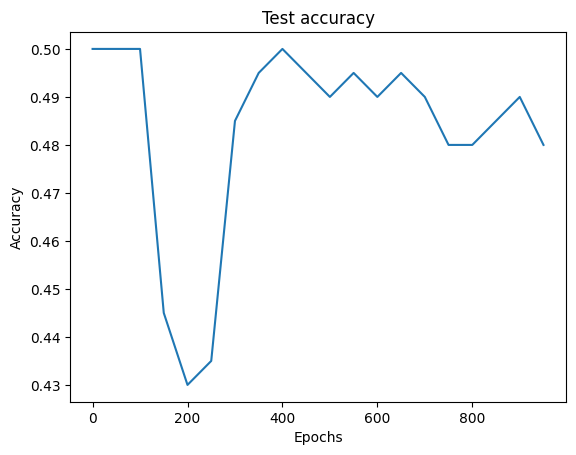

In [49]:
# plotting accuracy
plt.plot(epoch_count, np.array(torch.tensor(test_accuracy_count).numpy()), label="Test accuracy")
plt.title("Test accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")

In [50]:
test_loss

[tensor(0.7283),
 tensor(0.7140),
 tensor(0.7061),
 tensor(0.7017),
 tensor(0.6992),
 tensor(0.6979),
 tensor(0.6970),
 tensor(0.6966),
 tensor(0.6962),
 tensor(0.6960),
 tensor(0.6959),
 tensor(0.6957),
 tensor(0.6956),
 tensor(0.6956),
 tensor(0.6955),
 tensor(0.6954),
 tensor(0.6953),
 tensor(0.6953),
 tensor(0.6952),
 tensor(0.6952)]

It looks like our model is not learning anything. 

So, to inspect it let's make some predictions and make them visual!

To do so, we're going to import a function called `plot_decision_boundary()`

In [51]:
def plot_decision_boundary(model: torch.nn.Module, X: torch.Tensor, y: torch.Tensor):
    """Plots decision boundaries of model predicting on X in comparison to y.

    Source - https://madewithml.com/courses/foundations/neural-networks/ (with modifications)
    """
    # Put everything to CPU (works better with NumPy + Matplotlib)
    model.to("cpu")
    X, y = X.to("cpu"), y.to("cpu")

    # Setup prediction boundaries and grid
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101), np.linspace(y_min, y_max, 101))

    # Make features
    X_to_pred_on = torch.from_numpy(np.column_stack((xx.ravel(), yy.ravel()))).float()

    # Make predictions
    model.eval()
    with torch.inference_mode():
        y_logits = model(X_to_pred_on)

    # Test for multi-class or binary and adjust logits to prediction labels
    if len(torch.unique(y)) > 2:
        y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)  # mutli-class
    else:
        y_pred = torch.round(torch.sigmoid(y_logits))  # binary

    # Reshape preds and plot
    y_pred = y_pred.reshape(xx.shape).detach().numpy()
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())



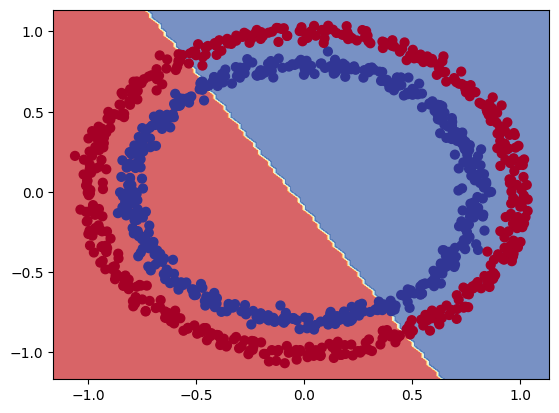

In [52]:
plot_decision_boundary(model_0, X, y)

### Improving our model (from a model's perspective) <a class="anchor" id="improve"></a>
* Add more layers
* Add more hidden units
* Fit for longer - more epochs
* Changing the activation function
* Changing the learning rate
* Changing the loss function

These options are all from a model's perspective because they deal directy with the model, rather than the data.
And because these options are all values we (as machine learning engineers and data scientists) can change, they are referred to as **hyperparameters**.

In [53]:
class CircleModelV1(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10)
        self.layer_3 = nn.Linear(in_features=10, out_features=1)

    def forward(self, x:torch.Tensor) -> torch.Tensor:
        return self.layer_3(self.layer_2(self.layer_1(x)))

model_1 = CircleModelV1()
model_1

CircleModelV1(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
)

In [54]:
# loss functions and optimizers
loss_fn = nn.BCEWithLogitsLoss() # cross entropy with sigmoid activation

optimizer = torch.optim.SGD(params=model_1.parameters(),
                            lr=0.01)
from sklearn.metrics import accuracy_score

epochs = 1000
epoch_count = []
train_loss = []
test_loss = []
test_accuracy_count = []

for epoch in range(epochs):
    model_1.train()
    y_logits = model_1(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits)) # turn logits into predictions
    
    loss = loss_fn(y_logits, y_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    model_1.eval()
    with torch.inference_mode():
        y_eval_logits = model_1(X_test).squeeze()
        y_eval = torch.round(torch.sigmoid(y_eval_logits))
        loss_test = loss_fn(y_eval_logits, y_test)
        test_accuracy = accuracy_score(y_pred=y_eval, y_true=y_test)
    if epoch%50==0:
        epoch_count.append(epoch)
        train_loss.append(loss)
        test_loss.append(loss_test)
        test_accuracy_count.append(test_accuracy)


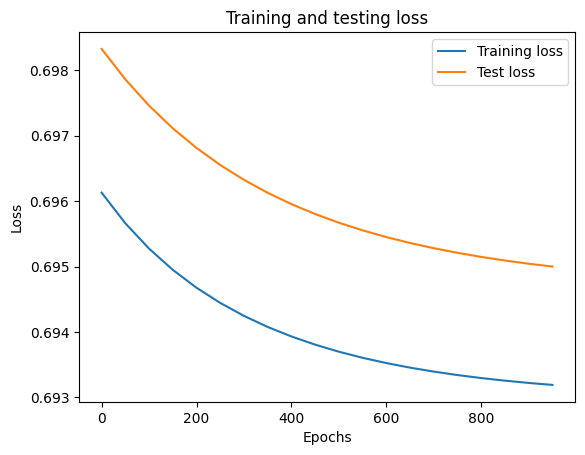

In [55]:
# plotting loss
plt.plot(epoch_count, np.array(torch.tensor(train_loss).numpy()), label="Training loss")
plt.plot(epoch_count, np.array(torch.tensor(test_loss).numpy()), label="Test loss")
plt.title("Training and testing loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

Text(0, 0.5, 'Accuracy')

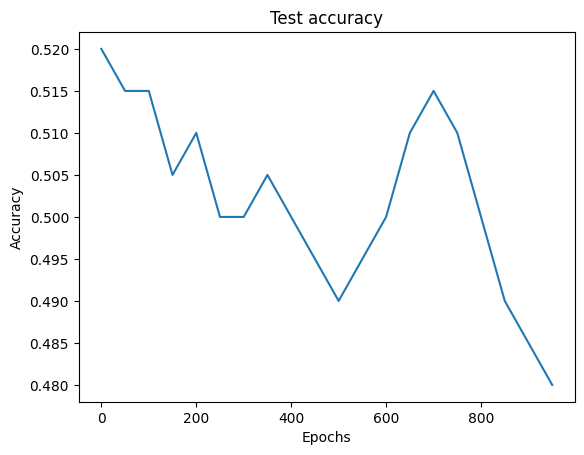

In [56]:
# plotting accuracy
plt.plot(epoch_count, np.array(torch.tensor(test_accuracy_count).numpy()), label="Test accuracy")
plt.title("Test accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")

### Non-linear activation

"What patterns could you draw if you were given an infinite amount of straight and non-straight lines?"
Or in machine learning terms, an infinite (but really it is finite) of linear and non-linear functions?

In [74]:
class NonlinearModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10)
        self.layer_3 = nn.Linear(in_features=10, out_features=1)
        self.relu = nn.ReLU()

    def forward(self, x):
        return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))

model_2 = NonlinearModel()
model_2

NonlinearModel(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

In [75]:
# loss functions and optimizers
torch.manual_seed(42)
loss_fn = nn.BCEWithLogitsLoss() # cross entropy with sigmoid activation

optimizer = torch.optim.SGD(params=model_2.parameters(),
                            lr=0.01)
from sklearn.metrics import accuracy_score

epochs = 1000
epoch_count = []
train_loss = []
test_loss = []
test_accuracy_count = []

for epoch in range(epochs):
    model_2.train()
    y_logits = model_2(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits)) # turn logits into predictions
    
    loss = loss_fn(y_logits, y_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    model_2.eval()
    with torch.inference_mode():
        y_eval_logits = model_2(X_test).squeeze()
        y_eval = torch.round(torch.sigmoid(y_eval_logits))
        loss_test = loss_fn(y_eval_logits, y_test)
        test_accuracy = accuracy_score(y_pred=y_eval, y_true=y_test)
    if epoch%50==0:
        epoch_count.append(epoch)
        train_loss.append(loss)
        test_loss.append(loss_test)
        test_accuracy_count.append(test_accuracy)


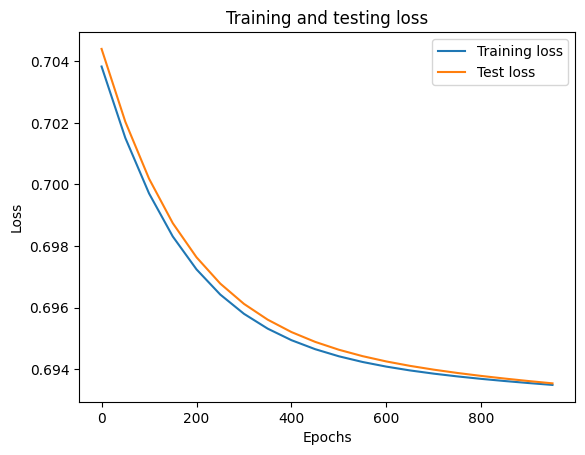

In [76]:
# plotting loss
plt.plot(epoch_count, np.array(torch.tensor(train_loss).numpy()), label="Training loss")
plt.plot(epoch_count, np.array(torch.tensor(test_loss).numpy()), label="Test loss")
plt.title("Training and testing loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

Text(0, 0.5, 'Accuracy')

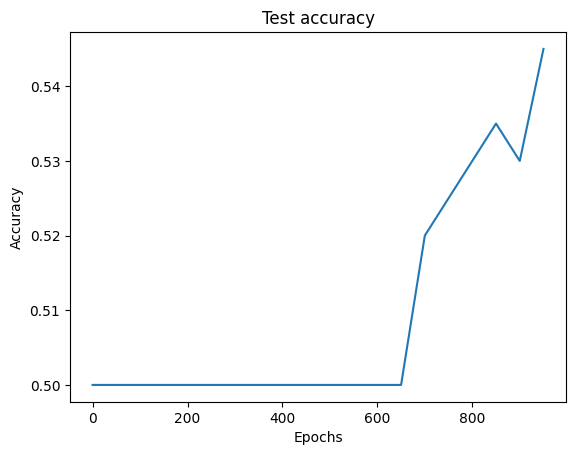

In [77]:
# plotting accuracy
plt.plot(epoch_count, np.array(torch.tensor(test_accuracy_count).numpy()), label="Test accuracy")
plt.title("Test accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")

In [61]:
relu_model = nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.ReLU(),
    nn.Linear(in_features=5, out_features=5),
    nn.ReLU(),
    nn.Linear(in_features=5, out_features=1)
)
relu_model

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): ReLU()
  (2): Linear(in_features=5, out_features=5, bias=True)
  (3): ReLU()
  (4): Linear(in_features=5, out_features=1, bias=True)
)

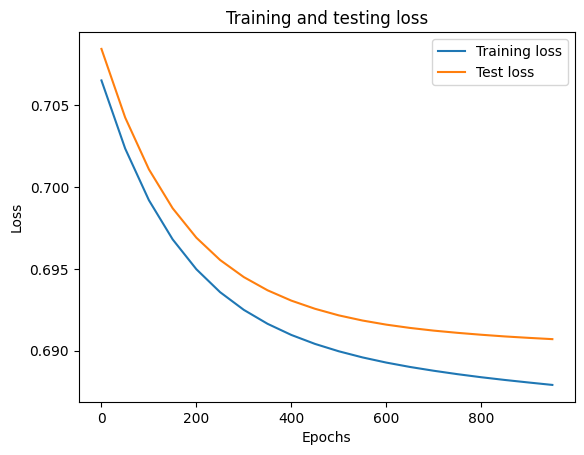

In [62]:
# loss functions and optimizers
loss_fn = nn.BCEWithLogitsLoss() # cross entropy with sigmoid activation

optimizer = torch.optim.SGD(params=relu_model.parameters(),
                            lr=0.01)
from sklearn.metrics import accuracy_score

epochs = 1000
epoch_count = []
train_loss = []
test_loss = []
test_accuracy_count = []

for epoch in range(epochs):
    model_2.train()
    y_logits = relu_model(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits)) # turn logits into predictions
    
    loss = loss_fn(y_logits, y_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    model_2.eval()
    with torch.inference_mode():
        y_eval_logits = relu_model(X_test).squeeze()
        y_eval = torch.round(torch.sigmoid(y_eval_logits))
        loss_test = loss_fn(y_eval_logits, y_test)
        test_accuracy = accuracy_score(y_pred=y_eval, y_true=y_test)
    if epoch%50==0:
        epoch_count.append(epoch)
        train_loss.append(loss)
        test_loss.append(loss_test)
        test_accuracy_count.append(test_accuracy)


# plotting loss
plt.plot(epoch_count, np.array(torch.tensor(train_loss).numpy()), label="Training loss")
plt.plot(epoch_count, np.array(torch.tensor(test_loss).numpy()), label="Test loss")
plt.title("Training and testing loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

Text(0, 0.5, 'Accuracy')

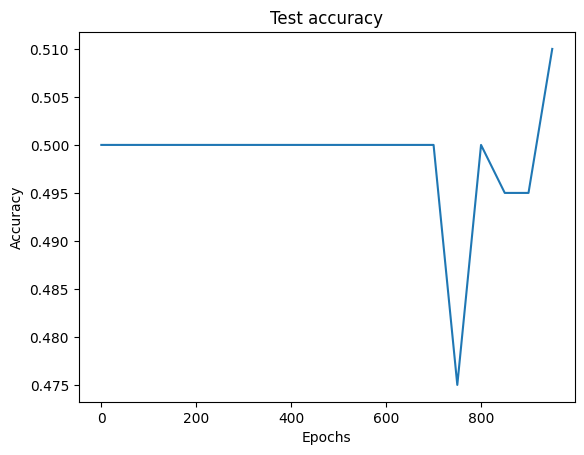

In [63]:
# plotting accuracy
plt.plot(epoch_count, np.array(torch.tensor(test_accuracy_count).numpy()), label="Test accuracy")
plt.title("Test accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")

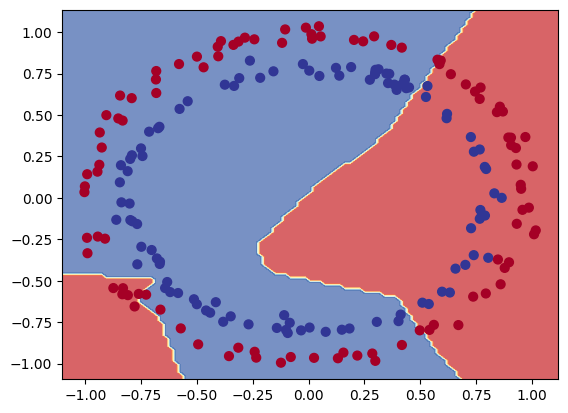

In [79]:
# plot decision boundary
plot_decision_boundary(model_2, X_test, y_test)